# SkullGAN: Synthetic Skull CT Generation with Generative Adversarial Networks

Access to a standardized, large enough database of human skull CTs for the purpose of training a neural network architecture on them is nearly impossible. As a result, simulation software written for transcranial ultrasound simulation generally verify their performance via one of the following:
1. Where multiplicity of data is necessary, they simulate toy models of the skull that are simple, homogeneous smooth manifolds. 
2. Where a single simulation is deemed sufficient in verifying their proposed simulation paradigm they use one or two  real human skull CT. 

For our purposes, we are building a neural network that estimates the transcranial pressure field simulated by k-wave (a MATLAB physics-based simulation software) at very high resolutions but at least 1000 times faster. Such a model needs hundreds of thousands of realistic human skulls for accurate verification. Therefore, instead of resorting to toy smooth manifolds as proxies for human skull, we are going to learn the underlying data generating distribution for real human skull CTs using SkullGAN, then sample from them as many realistic but synthetic human skulls as we need.

Paper: [KBP Lab](https://kbplab.stanford.edu/SkullGAN) <br>
Code: [GitHub](https://github.com/kbp-lab/SkullGAN)

<span style="color:blue">This notebook is meant solely for inferencing SkullGAN. To make for a cleaner notebook, it requires that you download the cli folder.</span>

## Step 1: Setup

We start by importing all of the necessary packages from PyTorch, NumPy, and other libraries.

In [4]:
## -------------------------------- ##
## IMPORT NECESSARY PACKAGES
## -------------------------------- ##

## ----- SYSTEM ----- ##
import os
import random

## ----- STATS ----- ##
import numpy as np

## ----- TORCH ----- ##
import torch
import torchvision.utils as vutils

## ----- DISPLAY ----- ##
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

## ----- MODEL / FUNCTIONS ----- ##
import sys
sys.path.insert(0, os.getcwd() + "/cli")
from functions import *
from model import *

## ----- REPRODUCIBILITY ----- ##
seed = 111
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.enabled = False
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(seed)
torch.backends.cudnn.deterministic = True

# Decide which device we want to run on
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if  torch.backends.mps.is_available() else "cpu")

## Step 2: Load Trained Model

Next, we initialize our models and load the pretrained model weights.

In [3]:
## ----- INITIALIZE MODELS ----- ##
netG = Generator(device).to(device)
netD = Discriminator(device).to(device)

## ----- LOAD PRETRAINED MODEL WEIGHTS ----- ##

# Model filenames and locations
netG_trained = "models/netG_SkullGAN.pth"
netD_trained = "models/netD_SkullGAN.pth"

# Load state dictionaries
netG_state_dict = torch.load(netG_trained, map_location = device)
netD_state_dict = torch.load(netD_trained, map_location = device)

# Remove 'module' prefix if not using DataParallel
netG_state_dict = {key.replace('module.', '') : value for key, value in netG_state_dict.items()}
netD_state_dict = {key.replace('module.', '') : value for key, value in netD_state_dict.items()}

# Load state dictionaries
netG.load_state_dict(netG_state_dict)
netD.load_state_dict(netD_state_dict)

print("Models Loaded!")

Models Loaded!


In [5]:
## ----- PRINT MODEL PARAMETER COUNTS ----- ##
print("Discriminator Parameter Count:", f"{count_parameters(netD):,}")
print("Generator Parameter Count:", f"{count_parameters(netG):,}")

Discriminator Parameter Count: 11,164,353
Generator Parameter Count: 192,002,304


## Step 3: Inference SkullGAN

We can now inference SkullGAN. Here, we generate 16 images and save them to a figure.

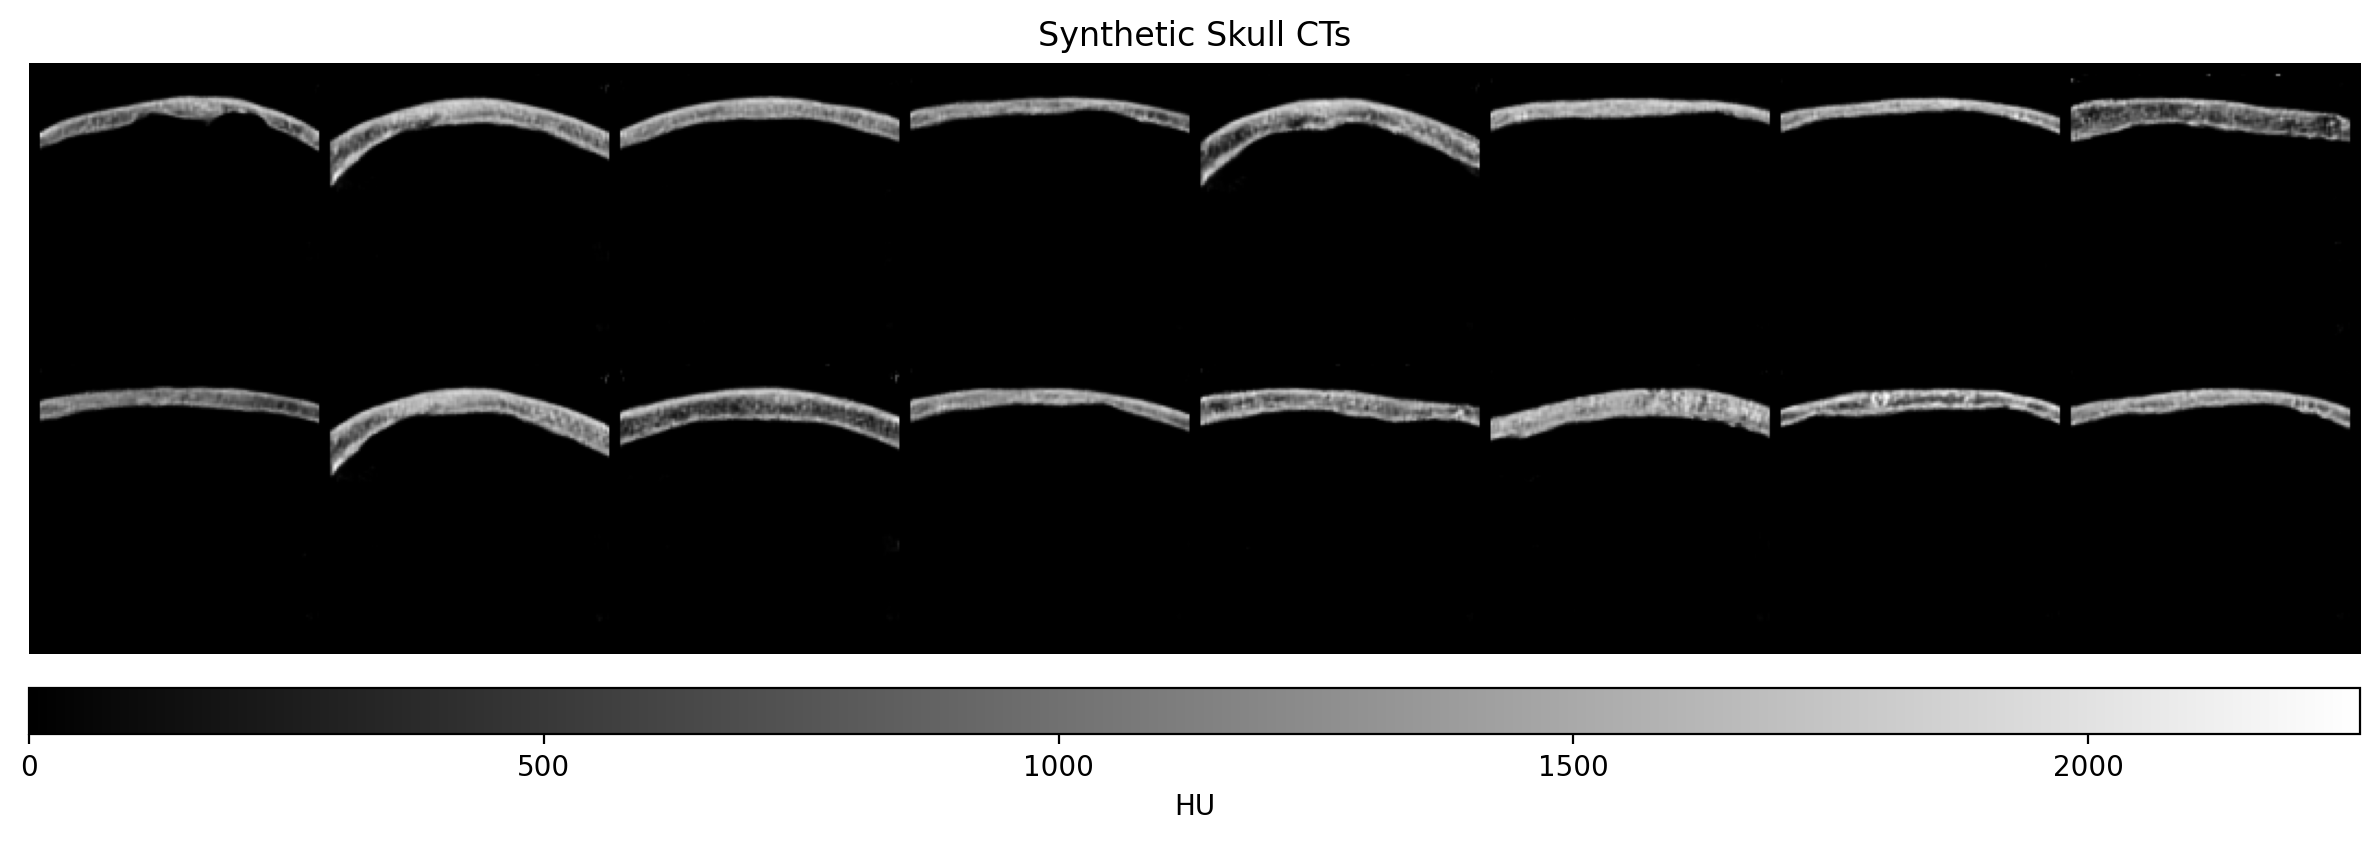

In [4]:
## ----- SHOW FAKE IMAGES ----- ##

# Number of images to generate
nimages = 16

# Normalization factor (SkullGAN -> HU)
skull_norm = 2264.084

# Generate some fake images
fake = netG(latent_vec(device, nimages, gen=latent_vec_gen))

# Create grid of images
fake_skulls = np.transpose(vutils.make_grid(fake, padding=5, normalize=True).cpu(),(1,2,0))

plt.figure(figsize=(12,6))
plt.imshow(fake_skulls, cmap = 'gray')
plt.colorbar(location = "bottom", aspect = 50, pad = 0.03, label = "HU")
plt.title("Synthetic Skull CTs")
plt.clim(0, skull_norm)
plt.axis("off")

plt.tight_layout()
plt.savefig("figures/Synthetic_Skull_CTs.png", dpi=600)
plt.show()

## Optional: Export Generated Segments 

In [6]:
## ----- EXPORT SAMPLES ----- ##

# Generate first fake image batch
test_samples = 50
test_noise = latent_vec(device, test_samples, gen=latent_vec_gen)
fake_slices = from_t(netG(test_noise)).squeeze() * skull_norm

# Generate and concatenate more batches
for i in range(9):
    test_noise = latent_vec(device, test_samples, gen=latent_vec_gen)
    fake_slices = np.concatenate((fake_slices, from_t(netG(test_noise)).squeeze() * skull_norm))

np.save("figures/SkullGAN_Inference.npy", fake_slices)